<!-- Assignment 4 - WS 2023 -->

# Adaptive Optimisation (22 points)

This notebook contains the fourth assignment for the exercises in Deep Learning and Neural Nets 1.
It provides a skeleton, i.e. code with gaps, that will be filled out by you in different exercises.
All exercise descriptions are visually annotated by a vertical bar on the left and some extra indentation,
unless you already messed with your jupyter notebook configuration.
Any questions that are not part of the exercise statement do not need to be answered,
but should rather be interpreted as triggers to guide your thought process.

**Note**: The cells in the introductory part (before the first subtitle)
perform all necessary imports and provide utility function that should work without problems.
Please, do not alter this code or add extra import statements in your submission, unless it is explicitly requested!

<span style="color:#d95c4c">**IMPORTANT:**</span> Please, change the name of your submission file so that it contains your student ID!

In this assignment, the goal is to get familiar with some of the most common (adaptive) **optimisation algorithms**. Essentially, the most common optimisation algorithms are nothing more than variants of gradient descent. Although it is often claimed that stochastic gradient descent outperforms any adaptive learning method when carefully configured, it is often more convenient to use a method that requires less tuning.

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

from nnumpy import Module
from nnumpy import Optimiser
from nnumpy.data import get_mnist_data
from nnumpy.utils import split_data, to_one_hot

%matplotlib inline

In [ ]:
def accuracy(logits, labels):
    """
    Compute accuracy for classification network.
    
    Parameters
    ----------
    logits : ndarray
        The logit-predictions from the network.
    labels : ndarray
        The target labels for the task.
    
    Returns
    -------
    acc : float
        The fraction of correctly classified samples.
    """
    idx = np.argmax(logits, axis=1)
    return np.mean(labels[np.arange(len(idx)), idx])

    
def plot_curves(model, train_errors, valid_errors):
    """
    Plot learning curves
    
    Parameters
    ----------
    model : Module
        The network to plot learning curves for.
    train_errors : ndarray
        The training errors for each batch in every epoch.
    valid_errors : ndarray
        The validation errors after each epoch.
    """
    plt.title("learning curves")
    train_acc, = evaluate(model, accuracy, Dataloader(*train_data))
    loss_curve, = plt.semilogy(np.mean(train_errors, axis=1), 
                           label=f'train (acc: {100 * train_acc:2.2f}%)')
    valid_acc, = evaluate(model, accuracy, Dataloader(*valid_data))
    plt.semilogy(valid_errors, linestyle='--', color=loss_curve.get_color(), 
             label=f'valid (acc: {100 * valid_acc:2.2f}%)')
    plt.legend()
    return plt.gcf()

## Gradient Descent

As you should know by now, the *backpropagation* algorithm is little more than a combination of the chain rule and some form of gradient descent. Although this happens to work well in practice, it is good to be aware of possible issues when using first-order optimisation methods:

 1. Gradient descent can/will get stuck in *local minima*.
 2. The *gradient magnitude* tells you nothing about how far away minima are.
 3. When optimising the *empirical error*, gradient descent would require the gradient over the entire dataset.

Note that this last point is not necessarily an issue, but it is useful to keep in mind. Also, it implies that the gradients that can be computed on the entire dataset do not need to correspond to the gradients that would be required to minimise the generalisation error.

### Exercise 1: Stochasticity (3 Points)

Rather than using plain gradient descent algorithm, a stochastic variant is used to train neural networks. This variant is known as *Stochastic Gradient Descent*, or *SGD* for short. Although this naming scheme seems to suggest that stochasticity is part of the algorithm, it is actually introduced by how we use the data to compute gradients.

Instead of computing the gradients over the entire dataset in one go, the samples in the dataset are split up in more manageable pieces called *mini-batches*. This can speed up the computations significantly and avoids memory problems with very large datasets. Another benefit from mini-batches is that they introduce variation, or *stochasticity*, in the gradient computations. After all, the gradient for each mini-batch will be different to the gradient for other mini-batches or for all samples. This stochasticity can be useful to escape local minima in the optimisation process. To amplify this stochasticity, it is also common to shuffle the samples in the dataset so that mini-batches consist of different samples.

> Complete the `Dataloader` class below to process the data in mini-batches of pre-specified size. Also make sure to shuffle the data to get more stochasticity.

##### Some Notes on python generators

In python, a [generator](https://wiki.python.org/moin/Generators) is a function with some state that can return multiple values. You probably have already used generators without realising it. Probably, the most famous generator is `range`, which could be defined as follows:
```python
def _range(start, stop, step=1):
    i = start
    while i < stop:
        yield i
        i += step
```

Notice the `yield` keyword. This has a similar effect as `return` in that it provides a value to the outer scope of the function. However, it does not cause the function to be exited. Instead, the current state in the function is stored until the next value is requested. To get the return values of a generator, there are essentially two options:
 1. Using the `next` function. This will simply run the function until the next `yield` statement and give back the yielded value.
 2. By iterating over the generator in any way. This will consequently call `next` on the generator until the function exits.
 
For more information, please refer to the internet.

In [ ]:
class Dataloader:
    
    def __init__(self, x, y, batch_size=None, shuffle=False, seed=None):
        """
        Parameters
        ----------
        x : (N, ...) ndarray
            the `N` input samples in the dataset
        y : (N, ...) ndarray
            the `N` output samples in the dataset
        batch_size : int, optional
            number of samples to include in a single mini-batch.
        shuffle : bool, optional
            whether or not the data should be shuffled.
        seed : int, optional
            seed for the pseudo random number generator used for shuffling.
        """
        self.x = x
        self.y = y
        self.batch_size = len(x) if batch_size is None else int(batch_size)
        self.shuffle = shuffle
        self.rng = np.random.default_rng(seed)
    
    def __iter__(self):
        """
        Iterates over the samples of the data.
        
        Yields
        ------
        x : ndarray
            input features for the batch
        y : ndarray
            target values for the batch
            
        Notes
        -----
        Each batch should contain the specified number of samples,
        except for the last batch if the batch_size does 
        not divide the number of samples in the data.
        """
        
        # shuffle data:
        number_samples = self.x.shape[0]

        if self.shuffle:
            shuffler = np.random.permutation(number_samples)
            x = np.copy(self.x)[shuffler]
            y = np.copy(self.y)[shuffler]
        else:
            x = np.copy(self.x)
            y = np.copy(self.y)
        
        # create mini-batches:
        if number_samples % self.batch_size == 0: # number batches fit into the number of samples:
            number_batches = int(number_samples/self.batch_size)
        else:
            number_batches = int(number_samples/self.batch_size)+1 
            # +1 because incomplete last batches are included

        for single_batch_ind in range(1,number_batches+1): 
            # +1 because else number_batches value not included in for-loop;
            # we don't need the looping variable single_batch_ind but the loop as counter how many 
            # mini-batches we can build

            if single_batch_ind == number_batches: # we reached the end of our last mini-batch
                minibatch_x, minibatch_y = x, y

            else:
                minibatch_x, minibatch_y = x[:self.batch_size], y[:self.batch_size]
                x, y = x[self.batch_size:], y[self.batch_size:]

            yield minibatch_x, minibatch_y # gives us a tuple     
            
            
                    
    def __len__(self):
        return -(-len(self.x) // self.batch_size)

In [ ]:
# sanity check
x = np.arange(7)
data_loader = Dataloader(x, np.copy(x), batch_size=3, shuffle=True, seed=17)
print(len(data_loader))
for x, y in data_loader:
    print(x.shape, y.shape)
    print(x)

print(x, y)

### Exercise 2: Gradient Descent with Momentum (3 Points)

Another way to keep gradient descent from getting stuck in local minima is to use momentum. Momentum accumulates the gradient directions over different batches and accelerates/decelarates the descent when all gradients point in the same/different direction(s). This also means that the update does not directly use the magnitude of the gradient, but instead focuses on the direction. 

> Implement the `get_direction` and `init_state` methods for the gradient descent optimiser with momentum.

In [ ]:
class GradientDescent(Optimiser):
    """ NNumpy implementation of gradient descent. """

    def __init__(self, parameters, lr: float, momentum: float = 0.):
        """
        Parameters
        ----------
        momentum : float
            Momentum term for the gradient descent.
        """
        super().__init__(parameters, lr)
        self.mu = momentum
        
        

    def init_state(self, par):
        """
        Create the initial optimiser state for a parameter.

        Parameters
        ----------
        par : Parameter
            The parameter to create the initial state for.

        Returns
        -------
        state : object or tuple of objects
            The initial optimiser state for the given parameter.
        """

        # initalize with 0:
        return np.zeros_like(par.grad)
        
    def get_direction(self, grad, state):
        """
        Compute the update direction from gradient and state for single parameter.

        Parameters
        ----------
        grad : ndarray
            Gradient for the parameter to update.
        state : object or tuple of objects
            State information that is necessary to compute the update direction.

        Returns
        -------
        direction : ndarray
            The update direction according to the algorithm.
        new_state: object or tuple of objects
            Updated state information after computing the update direction.
        """
        # nnumpy -> __init__.py --> class Optimiser --> def step:
        # updates w with w = w - lr delta_w, where delta_w is the FIRST return-
        # value from get_direction(). Therefore, delta_w = direction = m
        # = mu * m + (1 - mu) * grad.
        # This forms the solution here:
        direction = self.mu * state + (1 - self.mu) * grad
        
        # 'The optimizer state is the optimizer's momentum vector or similar history-tracking properties.'
        # (https://stats.stackexchange.com/questions/444328/what-does-it-mean-to-save-optimizer-states-in-deep-learning-libraries):
        new_state = direction # maybe time lr
        
        return direction, new_state 
        
 
        


### Exercise 3: The Adamax Optimiser (5 Points)

Momentum already provides a way to reduce the importance of the gradient magnitude. 
With adaptive learning rate methods, an attempt is made to ignore most of the magnitude information and the size of the update is mainly controlled by controlling the learning rate. 
One of the most popular first order adaptive methods in practice, is the Adam optimiser.
However, Adam also has a sibling called *Adamax* that typically performs on a similar level.

To understand Adamax, we have to look at the variance as a rescaled $L_2$ norm.
Instead of dividing by the $L_2$ norm, as it is done in Adam, Adamax divides by the $L_\inf$ norm.
This gives rise to the following updates for first and second moment estimates:

$$\begin{aligned}
    \boldsymbol{m}^{(t)} &= \beta_1 \boldsymbol{m}^{(t-1)} + (1 - \beta_1) \boldsymbol{g}^{(t)} \\
    \boldsymbol{u}^{(t)} &= \max\Bigl(\beta_2 \boldsymbol{u}^{(t-1)}, \bigl|\boldsymbol{g}^{(t)}\bigr|\Bigr),
\end{aligned}$$

giving rise to the update:

$$\boldsymbol{w}^{(t+1)} = \boldsymbol{w}^{(t)} - \eta \frac{1}{\boldsymbol{u}^{(t)} + \epsilon} \odot \boldsymbol{m}^{(t)}.$$

> Implement the `get_direction` and `init_state` methods for the Adamax optimisation algorithm.
> Also, make sure to implement a bias correction for the exponential moving averages.

In [ ]:
class Adamax(Optimiser):
    """ NNumpy implementation of the Adam algorithm. """

    def __init__(self, parameters, lr: float = 1e-3, betas: tuple = (.9, .999),
                 epsilon: float = 1e-7, bias_correction=True):
        """
        Parameters
        ----------
        betas : tuple of 2 floats, optional
            Decay factors for the exponential averaging of mean, resp. variance.
        epsilon : float, optional
            Small number that is added to denominator for numerical stability.
        bias_correction : bool, optional
            Whether or not mean and bias estimates should be bias-corrected.
        """
        super().__init__(parameters, lr)

        beta1, beta2 = betas
        self.beta1 = float(beta1)
        self.beta2 = float(beta2)
        self.eps = float(epsilon)
        self.bias_correction = bias_correction

    def init_state(self, par):
        """
        Create the initial optimiser state for a parameter.

        Parameters
        ----------
        par : Parameter
            The parameter to create the initial state for.

        Returns
        -------
        state : object or tuple of objects
            The initial optimiser state for the given parameter.
        """
        time = 1
        m, u = np.zeros_like(par.grad), 0#np.zeros_like(par.grad)
        state = (m, u, time)
        return  state

    def get_direction(self, grad, state):
        """
        Compute the update direction from gradient and state for single parameter.

        Parameters
        ----------
        grad : ndarray
            Gradient for the parameter to update.
        state : object or tuple of objects
            State information that is necessary to compute the update direction.

        Returns
        -------
        direction : ndarray
            The update direction according to the algorithm.
        new_state: object or tuple of objects
            Updated state information after computing the update direction.
        """
        m_old, u_old, time = state
        
        m_first_momentum = self.beta1 * m_old + (1 - self.beta1) * grad
        
        u_second_momentum_norm = max(np.max(self.beta2 * u_old), np.max(abs(grad)))
        # 'L-infinity norm: Gives the largest magnitude among each element of a vector.'
        # https://montjoile.medium.com/l0-norm-l1-norm-l2-norm-l-infinity-norm-7a7d18a4f40c
        
        new_state = m_first_momentum, u_second_momentum_norm, time + 1
        # save state before bias correction like in
        # https://stats.stackexchange.com/questions/232741/why-is-it-important-to-include-a-bias-correction-term-for-the-adam-optimizer-for


        # knowledge from: 
        # https://stats.stackexchange.com/questions/232741/why-is-it-important-to-include-a-bias-correction-term-for-the-adam-optimizer-for
        if self.bias_correction:
            m_first_momentum /= (1 - self.beta1 ** time)        
            # 'As u_t relies on the max operation, bias correction is not done for this term alone.'
            # (https://blog.allmattersai.com/adamax/)

            
        direction = m_first_momentum / (u_second_momentum_norm + self.eps)
           
        return direction, new_state 
        
        
        

## Training Networks

At this point, you should have all components that are necessary to start training neural networks.
With the modules you created throughout this semester, you can already build a wide variety of network architectures.
Together with the optimisers from this assignment, you can start training networks in your very own DL framework!
As a gift, I provide you with an extra module that is often useful when working with high-dimensional data.

In [ ]:
# import the modules you have written in previous assignments,
# or alternatively, the code for these modules, in this box.
# e.g. from nnumpy import Sequential, Linear, Conv2d, MaxPool2d, Tanh, LogitCrossEntropy
from nnumpy import Container, LossFunction
from nnumpy.utils import to_one_hot, sig2col

# The error function:
class LogitCrossEntropy(LossFunction): # from assignment 2 - MLP
    """
    NNumpy implementation of the cross entropy loss function
    computed from the logits, i.e. before applying the softmax nonlinearity.
    """

    def raw_outputs(self, logits, targets):

        """
        Computation of loss without reduction.

        Parameters
        ----------
        logits : (N, K) ndarray
        targets : (N, K) ndarray
        
        Returns
        -------
        cross_entropy : (N, 1) ndarray
        cache : ndarray or iterable of ndarrays
        """

        
        logits = logits - np.max(logits, axis=1,keepdims=True)
        softmaxed = np.exp(logits)/np.repeat(np.sum(np.exp(logits),axis=1).reshape(-1,1),logits.shape[1],axis=1)      
        cross_entropy = - np.sum(targets*np.log((softmaxed)),axis=1).reshape(-1,1)
        cache = targets,softmaxed 
        
        
        return cross_entropy, cache
    


    def raw_grads(self, grads, cache):
        """
        Computation of gradients for loss without reduction.

        Parameters
        ----------
        grads : (N, 1) ndarray
        cache : ndarray or iterable of ndarrays

        Returns
        -------
        dlogits : (N, K) ndarray
        dtargets : (N, K) ndarray
        """
        
        self.zero_grad()
        #targets,output,logits,log_softmaxed = cache
        targets,output=cache
        # extending the tutors stable solution from raw_outputs():
        
        dLdlogits = output - targets # = a(s) - y
        dlogits = grads * dLdlogits
        
        dLdy = np.log(1/output)
        dtargets = grads * dLdy
        
        return dlogits, dtargets
         

In [ ]:
# assignment 2 - MLP:
# linear layer:
class Linear(Module):

    """
    NNumpy implementation of a fully connected layer.

    Attributes
    ----------
    in_features : int
        Number of input features (D) this layer expects.
    out_features : int
        Number of output features (K) this layer expects.
    use_bias : bool
        Flag to indicate whether the bias parameters are used.

    w : Parameter
        Weight matrix.
    b : Parameter
        Bias vector.

    Examples
    --------
    >>> fc = Linear(10, 1)
    >>> fc.reset_parameters()  # init parameters
    >>> s = fc.forward(np.random.randn(1, 10))
    >>> fc.zero_grad()  # init parameter gradients
    >>> ds = fc.backward(np.ones_like(s))
    """
    
    def __init__(self, in_features, out_features, use_bias=True):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.use_bias = use_bias
        
        # register parameters 'w' and 'b' here (mind use_bias!)
        
        # only considering shape becsaue below with self.reset_parameters() random values initialized
        self.w = self.register_parameter('w', np.empty((self.out_features,self.in_features)))
        if use_bias == True:
            self.b = self.register_parameter('b',np.empty((self.out_features,)))
        
        self.reset_parameters()
        
        
        
    def reset_parameters(self, seed: int = None):
        """ 
        Reset the parameters to some random values.
        
        Parameters
        ----------
        seed : int, optional
            Seed for random initialisation.
        """
        rng = np.random.default_rng(seed)
        self.w = rng.standard_normal(size=self.w.shape)
        if self.use_bias:
            self.b = np.zeros_like(self.b)
    
    def compute_outputs(self, x):
        """
        Parameters
        ----------
        x : (N, D) ndarray

        Returns
        -------
        s : (N, K) ndarray
        cache : ndarray or iterable of ndarrays
        """
        

        if self.use_bias==True:
            s = x @ self.w.T + self.b
        else:
            s = x @ self.w.T
        cache = x

        return s, cache 
        
    
    def compute_grads(self, grads, cache):
        """
        Parameters
        ----------
        grads : (N, K) ndarray
        cache : ndarray or iterable of ndarrays

        Returns
        -------
        dx : (N, D) ndarray
        """
        # grads = dL/ds
        # dL/dw = dL/ds * ds/dw = grads * (xw.T+b)/dw
        self.zero_grad()

        x = cache
        

        if self.use_bias == True:
            b_grad = np.ones((grads.shape))
            self.b.grad = np.diag(grads.T @ b_grad)
  
        self.w.grad = grads.T @ x

       
        dx = grads @ self.w 

        return dx # = dL/dx

In [ ]:
# assignment 2:
# connect single layers in general:
class Sequential(Container):
    """
    NNumpy module that chains together multiple one-to-one sub-modules.
    
    Examples
    --------
    Doubling a module could be done as follows:
    >>> module = Module()
    >>> seq = Sequential(module, module)
    
    Modules can be accessed by index or by iteration:
    >>> assert module is seq[0] and module is seq[1]
    >>> mod1, mod2 = (m for m in seq)
    >>> assert mod1 is module and mod2 is module
    """

    def __init__(self, *modules):
        super().__init__()
        if len(modules) == 1 and hasattr(modules[0], '__iter__'):
            modules = modules[0]
        
        for i, mod in enumerate(modules):
            self.add_module(mod)

    def compute_outputs(self, x):
        """
        Parameters
        ----------
        x : (N, D) ndarray

        Returns
        -------
        y : (N, K) ndarray
        cache : ndarray or iterable of ndarrays
        """

    
        result = self._modules[0](x)
        result_list = [x,result]

        
        for single in self._modules[1:]:

            result = single(result)
            result_list.append(result)
            
        y = result
        cache = result_list

        return y, cache

    
    def compute_grads(self, grads, cache):
        """
        Parameters
        ----------
        grads : (N, K) ndarray
        cache : ndarray or iterable of ndarrays

        Returns
        -------
        dx : (N, D) ndarray
        """
        
        # go backward through all modules (linear layers; activation functions) by computing the gradient
        # starting with dL/da as given grads as input of gradient computation of last layer activation
        # function. Then reuse the grads_new = dL/ds = dL/da * da/ds where a=a(s)=activation_func(s) 
        # to put it into grad computation linear layer such that grads_new_new_w = dL/dw =
        # = dL/ds * ds/dw = dL/da * da/ds  *    d(x@w.T+b)/dw 
        # For dx and db replace simply the 'dw' by
        # 'dx','db'.

        result_list = cache
        result_list.reverse() # [prediction, .... , x]
            
        list_mod = self._modules.copy()
        list_mod.reverse()
        
        self.zero_grad() # new

        for ind,single_after in enumerate(list_mod):

            # new - but indeed the same as old version:
            net_x = result_list[ind+1] # output_before
            s,cache = single_after.compute_outputs(net_x)

            grads = single_after.compute_grads(grads, cache)
            
          
        dx = grads
                
        
        return dx
    

In [ ]:
class AlgebraicSigmoid(Module): # assignment 2
    """ 
    NNumpy implementation of an algebraic sigmoid function.
    """

    def compute_outputs(self, s):
        """
        Parameters
        ----------
        s : (N, K) ndarray
        
        Returns
        -------
        a : (N, K) ndarray
        cache : ndarray or iterable of ndarrays
        """
        
        a = s/np.sqrt(1+(s**2))
        cache = s
        
        return a, cache
        

    def compute_grads(self, grads, cache):
        """
        Parameters
        ----------
        grads : (N, K) ndarray
        cache : ndarray or iterable of ndarrays

        Returns
        -------
        ds : (N, K) ndarray
        """
        
        dads =  1/((cache**2+1)**1.5)
        ds = grads * dads
        return ds



In [ ]:
# assignment 3 - CNN - contents:

# all needed stuff already imported

# Convolution operation:
def multi_channel_convolution2d(x, k):
    """
    Compute the multi-channel convolution of multiple samples.
    
    Parameters
    ----------
    x : (N, Ci, A, B)
    k : (Co, Ci, R1, R2)
    
    Returns
    -------
    y : (N, Co, A', B')
    
    See Also
    --------
    sig2col : can be used to convert (N, Ci, A, B) ndarray 
              to (N, Ci, A', B', R1, R2) ndarray.
    """
    
    # aim: bring x into the form as it is described in the sum above: 
    # (N, A', B', (Ci x R1 x R2))
    converted_x = sig2col(x, (k.shape[2],k.shape[3])) # (N, Ci, A', B', R1, R2)
    converted_x = np.swapaxes(converted_x,1,2) # (N, A', Ci, B', R1, R2)
    converted_x = np.swapaxes(converted_x,3,2) # (N, A', B', Ci, R1, R2)
    converted_x = converted_x.reshape((converted_x.shape[0],converted_x.shape[1],converted_x.shape[2],converted_x.shape[3]*converted_x.shape[4]*converted_x.shape[5]))
    # (N, A', B', (Ci x R1 x R2)) --> aim reached
    
    # next aim: bring k into the form as it is described in the sum above:
    # ((Ci x R1 x R2), Co)
    k = np.swapaxes(k,0,1) # (Ci, Co, R1, R2)
    k = np.swapaxes(k,1,2) # (Ci, R1, Co, R2)
    k = np.swapaxes(k,2,3) # (Ci, R1, R2, Co)
    k = k.reshape((k.shape[0]*k.shape[1]*k.shape[2],k.shape[3]))
    # ((Ci x R1 x R2), Co) --> aim reached

    
    # Using the sum concept as described in text above:
    y = converted_x @ k # (N, A', B', Co)
    
    # last aim: bring y into the given shape (N, Co, A', B')
    y = np.swapaxes(y,1,3) # (N, Co, B', A')
    y = np.swapaxes(y,2,3) # (N, Co, A', B') --> aim reached
    
    return y
    
# Convolutional layer:
class Conv2d(Module):
    """ Numpy DL implementation of a 2D convolutional layer. """
    
    def __init__(self, in_channels, out_channels, kernel_size, use_bias=True):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.use_bias = use_bias
        
        # register parameters 'w' and 'b' here (mind use_bias!)

        self.w = self.register_parameter('w', np.empty((self.out_channels, self.in_channels, self.kernel_size[0],self.kernel_size[1])))
        if use_bias:
            self.b = self.register_parameter('b',np.empty((self.out_channels,)))
            # one bias scalar per feature map
        
        self.reset_parameters()
        
    def reset_parameters(self, seed: int = None):
        """ 
        Reset the parameters to some random values.
        
        Parameters
        ----------
        seed : int, optional
            Seed for random initialisation.
        """
        rng = np.random.default_rng(seed)
        self.w = rng.standard_normal(size=self.w.shape)
        if self.use_bias:
            self.b = np.zeros_like(self.b)
        
    def compute_outputs(self, x):
        """
        Parameters
        ----------
        x : (N, Ci, H, W) ndarray
        
        Returns
        -------
        feature_maps : (N, Co, H', W') ndarray
        cache : ndarray or tuple of ndarrays
        """
   
        
        feature_maps = multi_channel_convolution2d(x, self.w) 
        
        if self.use_bias:
            feature_maps = np.swapaxes(feature_maps,0,1)
            
            for ind,ele in enumerate(feature_maps):
                feature_maps[ind] += self.b[ind] # add to each feature map one
                # bias scalar
            
            feature_maps = np.swapaxes(feature_maps,0,1)

        
        cache = x
        
        return feature_maps, cache
    
    def compute_grads(self, grads, cache):
        """
        Parameters
        ----------
        grads : (N, Co, H', W') ndarray
        cache : ndarray or tuple of ndarrays
        
        Returns
        -------
        dx : (N, Ci, H, W) ndarray
        """
        
        self.zero_grad()
        
        x = cache
        
        # dw:
        # grads as dL/ds = delta_error
        grads2 = np.swapaxes(grads,1,0) # (Co, N, H', W')
        x = np.swapaxes(x,0,1) # (Ci, N, H, W) because we have for 
        # multi_channel_convolution2d(x,k) x.shape=(_,Ci,_,_), 
        # k.shape=(_,Ci,_,_) --> Both have same dimension on second position
        # of the shape.
        dw = multi_channel_convolution2d(x,grads2) 
        dw = np.swapaxes(dw,0,1) # bring dw to shape of self.w
        self.w.grad = dw
        
        # db:
        if self.use_bias:
            
            grads3 = grads2.reshape(grads2.shape[0],grads2.shape[1]*grads2.shape[2]*grads2.shape[3])
            # grads3: (Co, (N * H' * W')) = (Co, A)
            db = np.sum(grads3, axis=1) 
            # because we have sum_over_a delta_Co,a * 1 where all shapes with
            # exception of Co vanish in a.
            self.b.grad = db
            
        # dx:
        w2 = np.swapaxes(self.w,0,1) # (Ci, Co, R1, R2)
        w2 = np.flip(w2,(2,3)) 

        size1 = int(self.kernel_size[0])-1
        size2 = int(self.kernel_size[1])-1
        
        # zero-pad grads for each outcoming channel Co, therefore use grads2
        # with (Co, N, H', W'). Reason: dx shall have shape of original input x.
        # The outcome feature_maps becomes smaller depending on the kernel size.
        # Therefore, make the grads in the shape of feature_maps bigger through
        # padding such that dx doesn't get too small.:
        grads_pad = np.pad(grads2, ((0,0),(0,0),(size1,size1),(size2,size2)), 'constant', constant_values=0)
        # at the first two shapes there shall be no 0-frame added, therefore
        # use (0,0). size1, size2 describe how wide the frame shall be on each
        # side relating to the belonging shape dimension of grads2.
        grads_pad2 = np.swapaxes(grads_pad,1,0) # (N, Co, H', W')
        dx = multi_channel_convolution2d(grads_pad2,w2) 
        
        return dx
    
# Activation functions:
class ReLU(Module):
    """ NNumpy implementation of the Rectified Linear Unit. """
        
    def compute_outputs(self, s):
        """
        Parameters
        ----------
        s : (N, K) ndarray
        
        Returns
        -------
        a : (N, K) ndarray
        cache : ndarray or iterable of ndarrays
        """
        
        cache = s
        
        a = np.clip(s,0,None) # replace negative values with 0
        
        return a, cache
    
    def compute_grads(self, grads, cache):
        """
        Parameters
        ----------
        grads : (N, K) ndarray
        cache : ndarray or iterable of ndarrays

        Returns
        -------
        ds : (N, K) ndarrays
        """
        
        # grads = dL/da 
        # dL/ds = grads * da/ds
        
        s = cache
        ds = np.clip(s,0,None)/s # d max(0,x)/d x = max(0,x)/x
        
        return ds

class ELU(Module):
    """ NNumpy implementation of the Exponential Linear Unit. """
    
    def __init__(self, alpha=1.):
        super().__init__()
        if alpha < 0:
            raise ValueError("negative values for alpha are not allowed")
        
        self.alpha = alpha
        
        
    def compute_outputs(self, s):
        """
        Parameters
        ----------
        s : (N, K) ndarray
        
        Returns
        -------
        a : (N, K) ndarray
        cache : ndarray or iterable of ndarrays
        """
        
        cache = s
        
        a = np.copy(s)
        a[np.where(s<=0)] = self.alpha * (np.exp(s[np.where(s<=0)])-1)
        
        return a, cache
    
    def compute_grads(self, grads, cache):
        """
        Parameters
        ----------
        grads : (N, K) ndarray
        cache : ndarray or iterable of ndarrays

        Returns
        -------
        ds : (N, K) ndarrays
        """
        s = cache
        
        ds = np.copy(s)
        ds[np.where(s<=0)] = self.alpha * np.exp(s[np.where(s<=0)])
        ds[np.where(s>0)] = 1
        
        return ds

# Pooling - reducing size:
class MaxPool2d(Module):
    """ Numpy DL implementation of a max-pooling layer. """

    def __init__(self, kernel_size):
        super().__init__()
        self.kernel_size = tuple(kernel_size)

    def compute_outputs(self, x):
        """
        Parameters
        ----------
        x : (N, C, H, W) ndarray

        Returns
        -------
        a : (N, C, H', W') ndarray
        cache : ndarray or tuple of ndarrays
        """
        # Getting the x indices and values suitable for the kernel, i.e. building
        # up kernel bites:
        input_indices = sig2col(np.arange(x.size).reshape(x.shape),self.kernel_size,stride=self.kernel_size)
        converted_x = sig2col(x,self.kernel_size,stride=self.kernel_size)
 
        # Draw the max value and its index out of each kernel bite:
        x_re = converted_x.reshape((converted_x.shape[0],converted_x.shape[1],converted_x.shape[2]*converted_x.shape[3],converted_x.shape[4]*converted_x.shape[5]))
        max_values_x = np.max(x_re, axis=3)
        where_max_values_x = np.argmax(x_re, axis=3)
        where_max_values_x = where_max_values_x.reshape((where_max_values_x.shape[0],where_max_values_x.shape[1],where_max_values_x.shape[2],1))
        # bring where_max_values_x into same shape length like x by adding
        # one dimension with size=1.
        
        # Bring found out array with max values into the wanted shape:
        # with stride=self.kernel_size we get:
        height_x_rows = int(x.shape[2]/self.kernel_size[0])
        width_x_col = int(x.shape[3]/self.kernel_size[1])
        a = max_values_x.reshape(max_values_x.shape[0],max_values_x.shape[1],height_x_rows,width_x_col)
        
        
        cache = x, x_re,  where_max_values_x,input_indices
        return a, cache
        
       
    def compute_grads(self, grads, cache):
        """
        Parameters
        ----------
        grads : (N, C, H', W') ndarray
        cache : ndarray or tuple of ndarrays

        Returns
        -------
        dx : (N, C, H, W) ndarray
        """
        
        # General idea: maxpooling: we have an area from with we draw the max.
        # For the derivative mark the max of the place as 1 because derivative of 
        # max(x) is 1. The other places as 0.
        
        self.zero_grad()
        
        x, x_re, where_max_values_x,input_indices = cache
        
        # Mark all indices places where x_re is maximal with 1:
        np.put_along_axis(x_re, where_max_values_x, 1 , axis=3)
        
        # collect all indices where x_re has NO max value in not_max_val:
        max_ind = x_re.shape[-1]
        not_max_val = np.ones((x_re.shape[0],x_re.shape[1],x_re.shape[2],max_ind-1),dtype='int')
        val_range = np.arange(max_ind).tolist()
        for ind_i,i in enumerate(where_max_values_x):
            for ind_j,j in enumerate(i):
                for ind_c,c in enumerate(j):
                    val_range_copy = np.copy(val_range).tolist()
                    
                    val_range_copy.remove(c[0])
                    not_max_val[ind_i,ind_j,ind_c] = np.array(val_range_copy,dtype='int')
        
        # Mark all indices places where x_re has no max as 0:
        np.put_along_axis(x_re, not_max_val, 0 , axis=3) 
        
        # Bring grads into shape such that it is mulitplicable with x_re:
        grads = grads.reshape((grads.shape[0],grads.shape[1],grads.shape[2]*grads.shape[3],1))
        grads2 = np.repeat(grads, x_re.shape[3] ,axis= 3)
        
        dx = grads2 * x_re
        
        # Reshape dx considering the indices of x-values where each value has 
        # to be places after the original order:
        j = np.arange(x.size).reshape(x.shape)
        ii = np.argsort(input_indices.flatten()) # getting indices
        # input indices has shape of x_re
        dx = (dx.flatten()[ii]).reshape((x.shape)) # dx has originally shape of 
        # x_re --> Flatten it like the input_indices above and then use the 
        # found indices order
        
        return dx




In [ ]:
# as 2:     
# activation functions:
class Identity(Module):
    """ NNumpy implementation of the identity function. """
        
    def compute_outputs(self, s):
        """
        Parameters
        ----------
        s : (N, K) ndarray
        
        Returns
        -------
        a : (N, K) ndarray
        cache : ndarray or iterable of ndarrays
        """
        
        a = s # we have out_neuron = activation_func(pre_activation) = I(s) = s
        
        cache = s
        
        return a, cache
    
    
    def compute_grads(self, grads, cache):
        """
        Parameters
        ----------
        grads : (N, K) ndarray
        cache : ndarray or iterable of ndarrays

        Returns
        -------
        ds : (N, K) ndarray
        """
        
        # we have input: grads = dLinear(a(s))/da(s)
        # we want output: dL/ds = dLinear(a(s))/da(s) * da(s)/ds = grads * da(s)/ds
        # for identity we get: da(s)/ds = 1 (np.ones)
        return grads
        
        
class Tanh(Module):
    """ NNumpy implementation of the hyperbolic tangent function. """
        
    def compute_outputs(self, s):
        """
        Parameters
        ----------
        s : (N, K) ndarray
        
        Returns
        -------
        a : (N, K) ndarray
        cache : ndarray or iterable of ndarrays
        """

        a = np.tanh(s)
        cache = s
        
        return a, cache
        
    
    def compute_grads(self, grads, cache): # I replaced a with cache by in description ache denoted
        """
        Parameters
        ----------
        grads : (N, K) ndarray
        cache : ndarray or iterable of ndarrays

        Returns
        -------
        ds : (N, K) ndarray
        """
        # grads = dL/da 
        # dL/ds = grads * da/ds
        
        tanh_ = np.tanh(cache)
        dads = ( 1 - tanh_ ** 2)
        ds = grads * dads
        return ds

        

In [ ]:
class Flatten(Module):
    """ NNumpy module to convert multi-dimensional outputs to a single vector. """
    
    def compute_outputs(self, x):
        return x.reshape(len(x), -1), x.shape
    
    def compute_grads(self, grads, shape):
        return grads.reshape(shape)

The goal of the remainder of this assignment will be to train a network on the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset.

In [ ]:
def process_data(x_train, y_train):
    x_train = x_train.reshape(-1, 1, 28, 28)
    y_train = to_one_hot(y_train)
    
    # NOTE: custom data processing is allowed
    x_train = np.pad(x_train, ((0, 0), (0, 0), (2, 2), (2, 2)))
    x_train = x_train - np.mean(x_train, axis=(1, 2, 3), keepdims=True)
    x_train = x_train / np.std(x_train, axis=(1, 2, 3), keepdims=True)
    
    return x_train, y_train

x_train, y_train = get_mnist_data()
print(x_train.shape)
x_train, y_train = process_data(x_train, y_train)
print(x_train.shape, y_train.shape)

### Exercise 4: Evaluation and Update (3 Points)

When using the optimisers to fit a neural network to a given set of data, we can effectively minimise the empirical error. However, we are actually interested in minimising the risk. Therefore, it is also useful to evaluate the network regularly on unseen data.

 > Implement the `evaluate`, and `update` functions so that they perform the training and evaluation computations, respectively, for one iteration (aka *epoch*) over the entire dataset. Make sure to return the loss values to get loss curves at the end of this assignment.
 
**Hint:** you can use the `step` method of the optimiser to update the parameters.

In [ ]:
def evaluate(network, metric, data_loader):
    """
    Evaluate a network by computing a metric for specific data.

    Parameters
    ----------
    network : Module
        A module that implements the network.
    metric : callable
        A function that takes logits and labels 
        and returns a scalar numpy array.
    data_loader : Dataloader
        The data loader that provides the batches.

    Returns
    -------
    values : ndarray
        The computed metric values for each batch in the data loader.
        computed metric values for each batch in the data loader.
    """
    network.eval()
    errors = np.array([])
    for mini_batch_x, mini_batch_y in data_loader: 

        logits = network.forward(mini_batch_x)
        error_one_batch = metric(logits, mini_batch_y)
        errors = np.append(errors, error_one_batch)
   
    values = np.array([np.sum(errors)/len(errors)]) # we only want one error values in the end

    return values

    
    
def update(network, loss, data_loader, optimiser):
    """
    Update a network by optimising the loss for the given data.
    
    Parameters
    ----------
    network : Module
        A module that implements the network.
    loss : Module
        Loss function module.
    data_loader : Dataloader
        The data loader that provides the batches.
    optimiser : Optimiser
        Optimisation algorithm to use for the update.
        
    Returns
    -------
    errors : ndarray
        The computed loss for each batch in the data loader.
    """
    network.train()
    loss.train()
    errors = np.array([])
    
    for mini_batch_x, mini_batch_y in data_loader: 

        logits = network.forward(mini_batch_x)
        
        network.zero_grad()
        error_one_batch = loss.forward(logits, mini_batch_y)
        errors = np.append(errors, error_one_batch)

        dlogits, dtargets = loss.backward(np.array([1]))
        dx = network.backward(dlogits) 

        optimiser.step() # no return value

    errors = np.array([np.sum(errors)/len(errors)]) # we only want one error values in the end
   
    return errors

In [ ]:
def train(train_loader, valid_loader, network, loss, optimiser, epochs=1):
    """
    Train a neural network with gradient descent.
    
    Parameters
    ----------
    train_loader : Dataloader
        Dataloader producing batches of input-target pairs.
    valid_loader : Dataloader
        Dataloader producing batches of input-target pairs.
    network : Module
        A module that implements the network.
    loss : Module
        Loss function module.
    optimiser : Optimiser
        Optimisation algorithm.
    epochs : int, optional
        Number of times to iterate the dataset.
        
    Returns
    -------
    train_errors : (epochs + 1, n_batches) ndarray
        Training error for each epoch and each batch.
    valid_errors : (epochs + 1, 1) ndarray
        Validation error for each epoch.
    """
    # log performance before training (for reference)
    train_errors = [evaluate(network, loss.eval(), train_loader)]
    valid_errors = [evaluate(network, loss.eval(), valid_loader)]
    
    print('start epoch')
    
    # train for given number of epochs
    for _ in range(epochs):
        train_errors.append(update(network, loss, train_loader, optimiser))
        print('training done')
        valid_errors.append(evaluate(network, loss.eval(), valid_loader))
        print('evaluation done')
        
        print('one epoch done')
    print('my train + valid errors',train_errors,valid_errors)
    return np.stack(train_errors), np.stack(valid_errors)

### Exercise 5: Training Logistic Regression (5 points)

To test your framework, it is best to start with a simple problem.
Therefore, we jump back to assignment one, where we learned that logistic regression is actually a single-layer network.
If your optimiser works correctly, the loss should go down when a sufficiently small learning rate was chosen.

 > Build a single-layer network from your own modules and train it to classify MNIST digits.
 > You can use the `train` function from the previous exercise.
 > Train your network for at least five epochs.
 > Use an adaptive optimiser to train your network with *stochastic* gradients.
 > The `split_data` function can be used to create a validation dataset.
 
**Hint:** the `Flatten` module I gifted earlier, might be useful for turning images into vectors.

In [ ]:
# import and prepare dataset:

# use previous code:
#x_train, y_train = get_mnist_data() # but of course we don't use x_train as x_train but as whole 
# dataset representation
#x_train, y_train = process_data(x_train, y_train)

flatter = Flatten()
x_vec, x_vec_shape = flatter.compute_outputs(x_train)

train_data, valid_data = split_data(x_vec,y_train)
train_data_x, train_data_y = train_data
val_data_x, val_data_y = valid_data

batch_size = 16*2*2*2*2 # 256
train_loader = Dataloader(train_data_x, train_data_y, batch_size, shuffle=True, seed=0)
val_loader = Dataloader(val_data_x, val_data_y, batch_size, shuffle=True, seed=0)



In [ ]:
# Network architecture
net = Sequential(
        Linear(in_features=x_vec.shape[1], out_features=val_data_y.shape[1]),
        AlgebraicSigmoid()
        )


loss = LogitCrossEntropy(reduction='none')
optimiser = Adamax(net.parameters(), lr = 1e-5, bias_correction = True)
# at this place we connect the optimizer with the parameters of the logistic regression

train_err, valid_err = train(train_loader, val_loader, net, loss, optimiser, epochs=20) 

In [ ]:
plot_curves(net, train_err, valid_err);

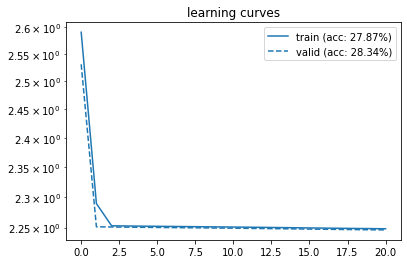

The accuracy is quite good for considering that we only used logistic regression.

### Exercise 6: Training a Multi-layer Network (3 Points)

It would have been silly to do all of this work to train logistic regression.
Something you probably already would have been able to do before the start of this course.
The real goal is to train *deep* networks with multiple layers.
You probably can't wait to build a convolutional network with your framework!

> Use one of the optimisers from above to train a multi-layer convolutional neural network on the MNIST dataset. 
> Feel free to also create new modules and try out new things! (make sure to include any new code in the notebook!).
> Achieve a model with 80% accuracy to collect all points. 
> For reference: the sample solution (using the LeNet architecture illustrated below) takes &approx;15&nbsp;min to train for 10&nbsp;epochs.

**Hint:** You can probably reuse a few things from the previous exercise.

<figure>
    <figcaption style="width: 100%; text-align: center;">LeNet-5 architecture</figcaption>
    <img src="https://miro.medium.com/max/2154/1*1TI1aGBZ4dybR6__DI9dzA.png" />
</figure>

In [ ]:
# Network architecture
cnn = Sequential(
    Conv2d(in_channels=x_train.shape[1], out_channels=6, kernel_size=(5,5), use_bias=True),
    # output_size = input_size - kernel_size + 1 = 32 - 5 + 1 = 28
    
    ELU(), # as we implemented it in assignment 3
    
    MaxPool2d(kernel_size=(2,2)), # keep only half of the size; in_size=28x28 out_size=14x14
    
    Conv2d(in_channels=6, out_channels=16, kernel_size=(5,5), use_bias=True),
    # in_size = 14 --> 14 + 1 - 5 = 10 = out-size --> kernel_size1=5.
    # the in_channels are the out_channels from the previous layer
    
    ELU(),
    
    MaxPool2d(kernel_size=(2,2)), # keep only half of the size; in_size=10x10 out_size=5x5
    
    
    # We have channels=16, in_size=5x5. Next we want to transform the layer such that we can use linear
    # layer. Therefore, get 120 output units in total. Only Conv2D can change the channel
    # number from the used modules.:
    Conv2d(in_channels=16, out_channels=120, kernel_size=(5,5), use_bias=True),
    ELU(),
    # Bring the output units to one level such that they can be used for the Linear Layer which only 
    # assumes one channel:
    Flatten(),
    
    Linear(in_features=120, out_features=84),
    
    AlgebraicSigmoid(), # used in logistic regression
    
    Linear(in_features=84, out_features=10)
    
)


     
loss = LogitCrossEntropy(reduction='none')
optimiser = GradientDescent(cnn.parameters(), lr = 1e-5)
# at this place we connect the optimizer with the parameters of the CNN

# This time x keeps its channel:
train_data, valid_data = split_data(x_train,y_train)

# limit dataset for computational weak devivces:
#train_data = (train_data[0][:10000], train_data[1][:10000])
#valid_data = (valid_data[0][:200], valid_data[1][:200])

train_data_x_cnn, train_data_y_cnn = train_data
val_data_x_cnn, val_data_y_cnn = valid_data


batch_size = 32 # 4
train_loader_cnn = Dataloader(train_data_x_cnn, train_data_y_cnn, batch_size, shuffle=True, seed=0)
val_loader_cnn = Dataloader(val_data_x_cnn, val_data_y_cnn, batch_size, shuffle=True, seed=0)

train_err, valid_err = train(train_loader_cnn, val_loader_cnn, cnn, loss, optimiser, epochs=10)

In [ ]:
valid_err

In [ ]:
plot_curves(cnn, train_err, valid_err);

Unluckily, the accuracy is quite low here, however, I want to make you aware that my computational power on my device is quite limited. Therefore, I was only able to use a low epoch number (3) and only a part of the dataset for training. Also the batch size is quite limited (4). Else my computer would stop working at all.<br>
For you I change my small code hyperparameters into the computational more heavy ones. However, because of my limitations I was not able to find out the perfect hyperparameter matches.

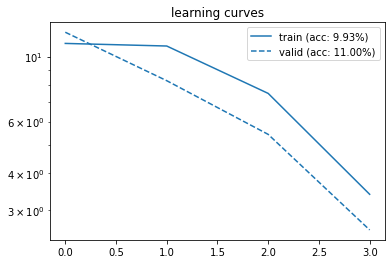